VOICE IDENTIFICATION USING CLASSIFICATION MODEL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
import csv

import librosa
import librosa.display

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras


EXPLORATORY DATA ANALYSIS FOR RAW AUDIO FILE

In [ ]:
# SPECTOGRAM 
color_map = plt.get_cmap('magma')
plt.figure(figsize=(8,8))

genres  = 'cat dog female male'.split()

for g in genres :
    pathlib.Path(f'images_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/drive/MyDrive/cluster/{g}'):
        voicename = f'/content/drive/MyDrive/cluster/{g}/{filename}'
        y, sr = librosa.load(voicename, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, noverlap=128, cmap=color_map, scale='dB');
        plt.axis('off');
        plt.savefig(f'images_data/{g}/{filename[:-3].replace("."," ")}.png')
        plt.clf()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 576x576 with 0 Axes>

In [ ]:
# MEL SPECTOGRAM
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))

genres = 'cat dog female male'.split()

for g in genres:
    pathlib.Path(f'mel_images_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./drive/My Drive/cluster/{g}'):
        voicename = f'./drive/My Drive/cluster/{g}/{filename}'
        y, sr = librosa.load(voicename,sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.axis('off')
        plt.savefig(f'mel_images_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 576x576 with 0 Axes>

In [ ]:
# DIRECTORY OF CERTAIN AUDIO FILES
cat_path=f'/content/drive/MyDrive/cluster/cat/cat_45.wav'
dog_path=f'/content/drive/MyDrive/cluster/dog/dog_barking_11.wav'
female_path=f'/content/drive/MyDrive/cluster/female/female_21.wav'
male_path=f'/content/drive/MyDrive/cluster/male/male_31.wav'

In [ ]:
# LOADING THE AUDIO FILE
cat_audio, sr =librosa.load(cat_path)
dog_audio, sr =librosa.load(dog_path)
female_audio, sr =librosa.load(female_path)
male_audio, sr =librosa.load(male_path)

In [ ]:
# SAMPLE CLIPS OF AUDIO FILE
import IPython.display as ipd
def play_audio(file_path):
  play = ipd.Audio(file_path)
  return play


In [ ]:
play_audio(cat_path)

In [ ]:
play_audio(dog_path)

In [ ]:
play_audio(female_path)

In [ ]:
play_audio(male_path)

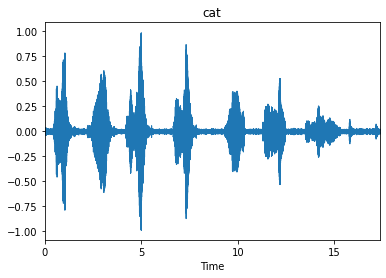

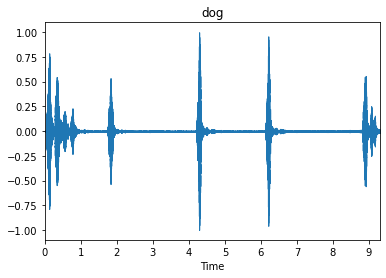

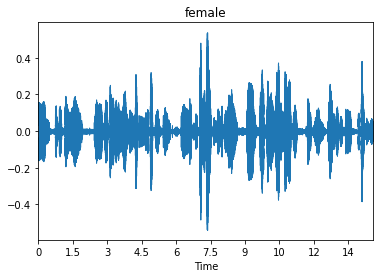

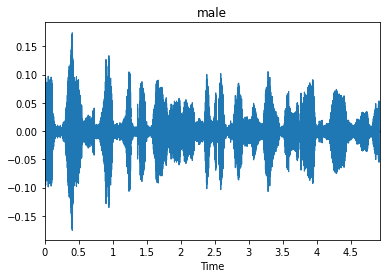

In [ ]:
# WAVE PLOT
def waveplot(title,file):
  plt.title(title)
  librosa.display.waveplot(file)
  show = plt.show()
  return show

waveplot("cat",cat_audio)
waveplot("dog",dog_audio)
waveplot("female",female_audio)
waveplot("male",male_audio)


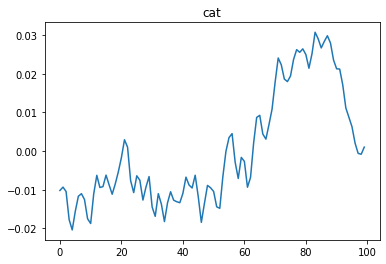

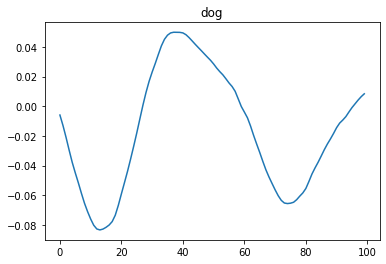

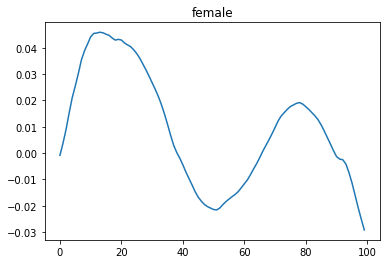

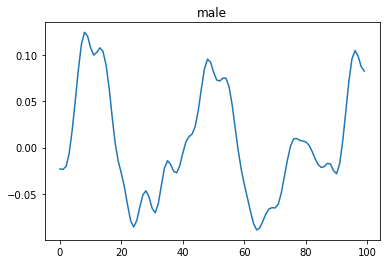

In [ ]:
# ZOOM IN PLOT
start = 9000
end = 9100
def zoomin(title,file):
  zero_crossings = librosa.zero_crossings(cat_audio[start:end], pad=False)
  plt.plot(file[start:end])
  plt.title(title)
  zoom = plt.show()
  return zoom

zoomin("cat",cat_audio)
zoomin("dog",dog_audio)
zoomin("female",female_audio)
zoomin("male",male_audio)

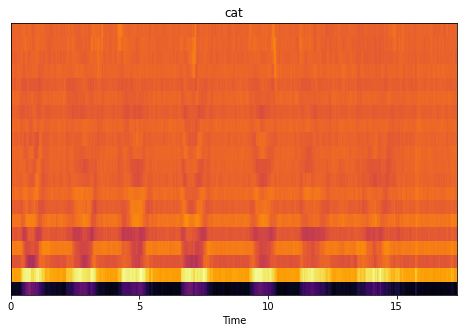

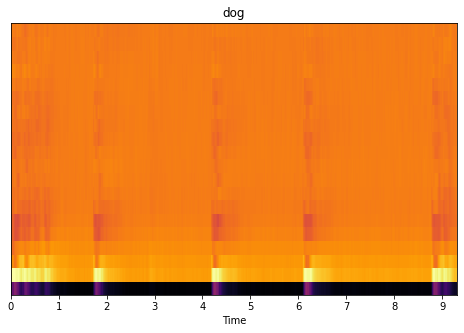

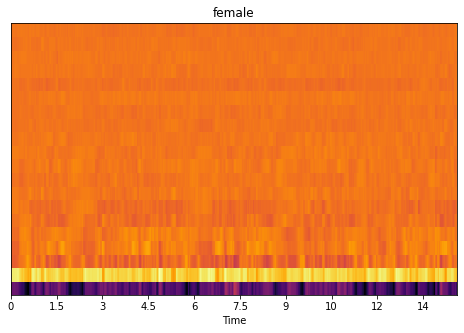

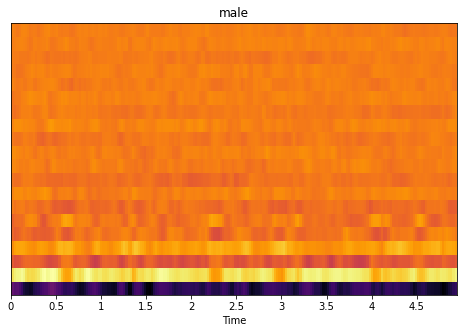

In [ ]:
# MEL FREQUENCY CEPSTRAL COEFFICIENT (MFCC)
def mfcc(title,file):
  mfccs = librosa.feature.mfcc(file, sr=sr)
  color_map = plt.get_cmap('inferno')
  plt.figure(figsize=(8,5)) 
  plt.title(title)
  m = librosa.display.specshow(mfccs, sr=sr,cmap=color_map, x_axis='time')
  return m

mfcc("cat",cat_audio)
mfcc("dog",dog_audio)
mfcc("female",female_audio)
mfcc("male",male_audio)

AUDIO FEATURE EXTRACTION + EDA 

In [ ]:
# HEADER FOR EACH COLUMNS
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# FEATURE EXTRACTED FILE
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'cat dog female male'.split()
for g in genres:
    for filename in os.listdir(f'./drive/My Drive/cluster/{g}'):
        voicename = f'./drive/My Drive/cluster/{g}/{filename}'
        y, sr = librosa.load(voicename, mono=True, duration=3)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [ ]:
# PREVIEW OF DATASET
AudioData=pd.read_csv('dataset.csv')
AudioData.head() 

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,cat_1.wav,0.551849,0.040750,1535.375499,1663.765222,3230.891489,0.078024,-286.337677,137.947861,-18.726990,45.497673,-10.894729,16.272608,-11.546696,3.796217,-4.267594,-0.296768,3.058976,-6.826207,1.948830,-8.669430,0.060729,-6.828735,0.503965,-5.934189,-2.955082,-2.001838,cat
1,cat_10.wav,0.381789,0.057671,2556.423783,1778.100348,4609.347769,0.162504,-339.646973,34.633308,-71.071770,43.209675,-30.058966,22.497496,-29.042053,16.585419,6.686013,4.020730,1.218535,-1.015494,2.733306,-17.680218,11.702271,0.092839,23.230286,22.897274,21.972176,9.439925,cat
2,cat_11.wav,0.421166,0.023636,1149.786463,1506.580490,2330.637958,0.050285,-365.387451,120.502869,15.878594,12.513811,8.562349,0.554221,-11.753662,-6.423113,-9.884990,-12.093536,-4.314541,-9.797238,-8.499317,-5.380761,-7.631447,-5.625026,-4.531232,-8.257047,-7.707338,-7.630582,cat
3,cat_36.wav,0.615769,0.017104,1380.626604,1689.935706,2820.021409,0.060708,-360.814789,146.666992,-24.010303,32.859570,-18.011541,35.893822,-8.061631,21.905045,-1.387991,4.673172,3.527170,-3.440296,6.671386,-8.320293,8.763371,-5.596245,6.144727,-4.728235,1.648204,0.988413,cat
4,cat_12.wav,0.492098,0.009460,1063.734235,1425.416315,2251.047927,0.039310,-417.449982,177.159912,-37.044518,56.516525,-13.136910,27.780588,-25.263567,10.296847,-19.314762,-11.232536,1.538378,-14.260868,-2.602324,-18.014017,-0.312757,-16.362375,0.403266,-9.304008,-6.969352,-7.481794,cat


In [ ]:
# DIMENSION OF THE DATASET
AudioData.shape

(204, 28)

In [ ]:
# INFORMATION ABOUT DATASET
AudioData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   filename            204 non-null    object 
 1   chroma_stft         204 non-null    float64
 2   rmse                204 non-null    float64
 3   spectral_centroid   204 non-null    float64
 4   spectral_bandwidth  204 non-null    float64
 5   rolloff             204 non-null    float64
 6   zero_crossing_rate  204 non-null    float64
 7   mfcc1               204 non-null    float64
 8   mfcc2               204 non-null    float64
 9   mfcc3               204 non-null    float64
 10  mfcc4               204 non-null    float64
 11  mfcc5               204 non-null    float64
 12  mfcc6               204 non-null    float64
 13  mfcc7               204 non-null    float64
 14  mfcc8               204 non-null    float64
 15  mfcc9               204 non-null    float64
 16  mfcc10  

In [ ]:
# SUMMARY OF DATASET
AudioData.describe().T

,count,mean,std,min,25%,50%,75%,max
chroma_stft,204.0,0.362328,0.110981,0.173096,0.286823,0.356576,0.412963,0.710001
rmse,204.0,0.077731,0.064284,0.004818,0.033679,0.054164,0.111863,0.327166
spectral_centroid,204.0,1509.183035,488.831238,506.718733,1157.232962,1478.296845,1811.213718,3403.907065
spectral_bandwidth,204.0,1430.561347,353.841538,664.763238,1202.925632,1498.622913,1704.757119,2185.112464
rolloff,204.0,2828.944677,1013.343590,759.045410,2119.322698,2855.634014,3562.896212,5676.566444
zero_crossing_rate,204.0,0.085333,0.035820,0.024230,0.060624,0.078101,0.103013,0.267717
mfcc1,204.0,-294.726545,84.024198,-515.031006,-342.757210,-297.953064,-238.501205,-73.281425
mfcc2,204.0,134.022808,32.948146,8.413162,115.195395,140.284134,156.967720,212.566925
mfcc3,204.0,-32.558902,25.960397,-120.380058,-49.084290,-31.876222,-17.708489,54.600811
mfcc4,204.0,24.899402,33.324890,-60.099487,7.794059,36.279039,48.007925,72.391563


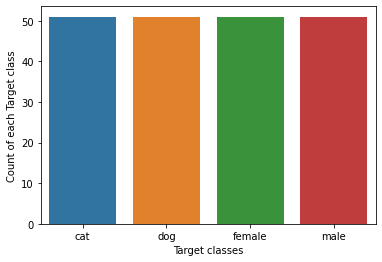

In [ ]:
# COUNT PLOT FOR TARGET CLASS
import seaborn as sns
sns.countplot(x=AudioData['label'] ,data=AudioData)
plt.ylabel("Count of each Target class")
plt.xlabel("Target classes")
plt.show()

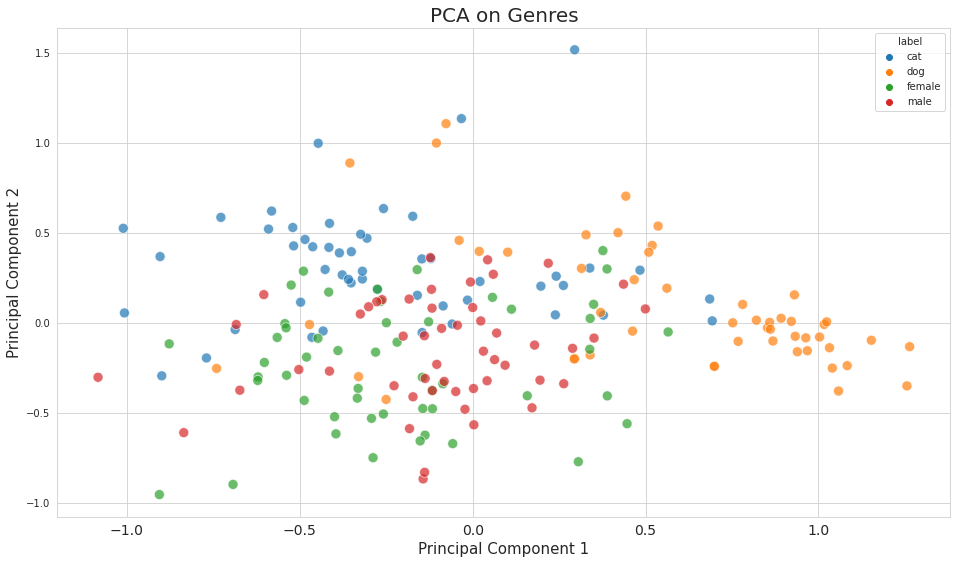

In [ ]:
# PRINCIPLE COMPONENT SCATTER PLOT

data = AudioData.iloc[0:, 1:]

X = data.loc[:, data.columns != 'label']
y = data['label']

import sklearn.preprocessing as skp
# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('whitegrid')

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

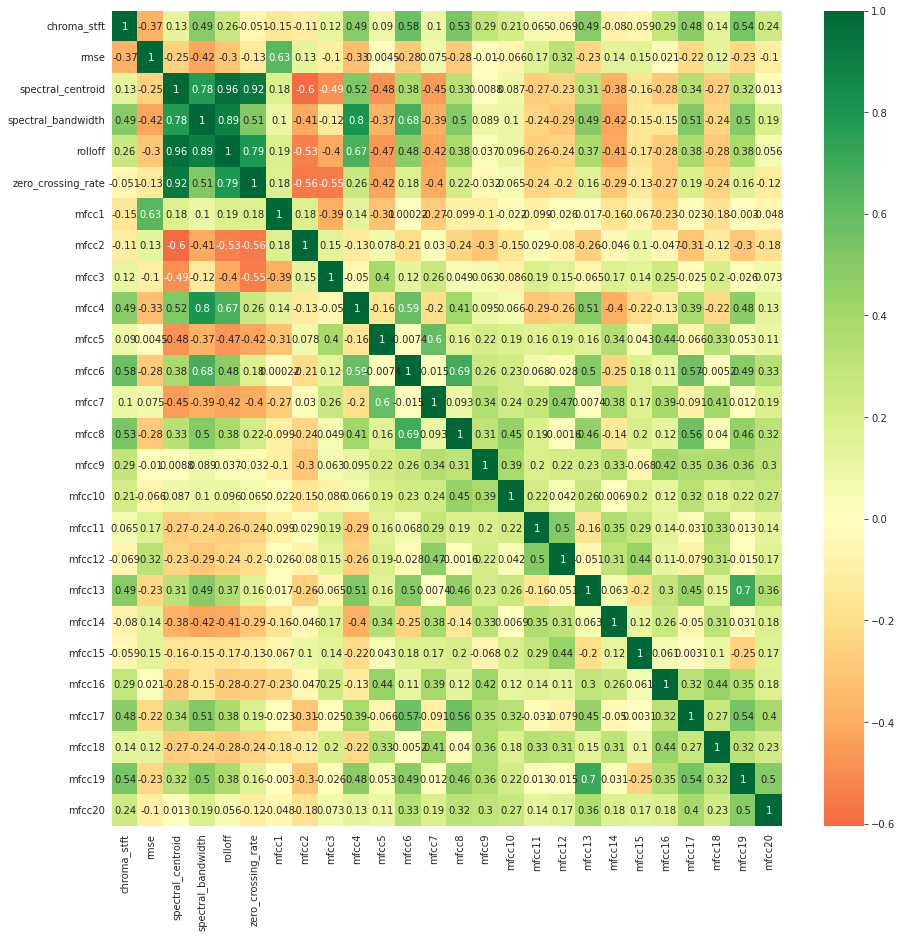

In [ ]:
# HEAT MAP
plt.figure(figsize=(15,15))
p=sns.heatmap(AudioData.corr(), annot=True,cmap='RdYlGn',center=0) 
plt.savefig("Corr_Heatmap.png")

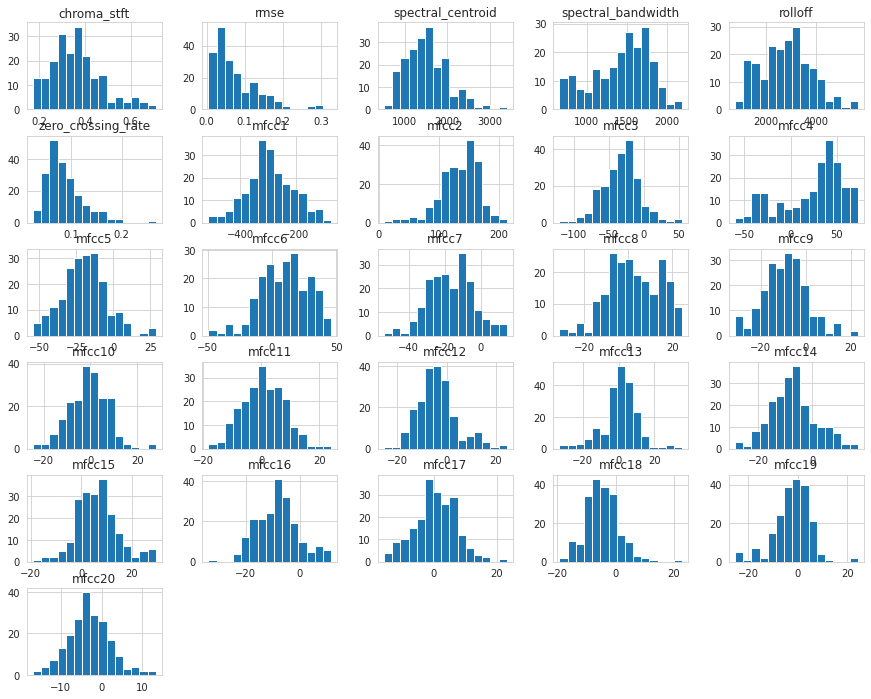

In [ ]:
# HISTOGRAM
AudioData.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

In [ ]:
# CHECKING MISSING VALUES
AudioData.isnull().sum()

filename              0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
label                 0
dtype: int64

In [ ]:
# EXPLORE TARGET VARIABLE
AudioData['label'].value_counts()

cat       51
male      51
dog       51
female    51
Name: label, dtype: int64

DATASET + PRE-PROCESSING

In [ ]:
import copy
data = copy.deepcopy(AudioData)

# ENCODE TARGET CLASS
data['label'],class_names = pd.factorize(data['label'])
class_names

# DROP OF UNUSED COLUMN
data.drop('filename',inplace=True,axis=1)

genre_list = data.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

# SCALE THE FEATURES COLUMNS
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

# SPLIT DATA INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)


ANN MODEL

In [ ]:
# SPLIT DATA INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 24)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# MODEL BUILDING
classifier = Sequential()
classifier.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(32, activation = 'softmax'))
#classifier.summary()

# COMPILE
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# FITTING THE ANN
model = classifier.fit(X_train, y_train, batch_size = 128, epochs = 100,verbose = 0)

# MODEL EVALUATION
Score , Accuracy= classifier.evaluate(X_test, y_test,batch_size=25)
print("ACCURACY OF ANN MODEL : ",Accuracy*100)



2/2 [==============================] - 0s 4ms/step - loss: 0.4108 - accuracy: 0.8780
ACCURACY OF ANN MODEL :  87.80487775802612


In [ ]:
import copy
data = copy.deepcopy(AudioData)

# ENCODE TARGET CLASS
data['label'],class_names = pd.factorize(data['label'])
class_names

# DROP OF UNUSED COLUMN
data.drop('filename',inplace=True,axis=1)

genre_list = data.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

# SCALE THE FEATURES COLUMNS
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

# SPLIT DATA INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 24)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# MODEL BUILDING
classifier = Sequential()
classifier.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(32, activation = 'softmax'))
#classifier.summary()

# COMPILE
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# FITTING THE ANN
model = classifier.fit(X_train, y_train, batch_size = 128, epochs = 100,verbose = 0)

# MODEL EVALUATION
Score , Accuracy= classifier.evaluate(X_test, y_test,batch_size=25)
print("ACCURACY OF ANN MODEL : ",Accuracy*100)



2/2 [==============================] - 0s 3ms/step - loss: 0.4939 - accuracy: 0.8780
ACCURACY OF ANN MODEL :  87.80487775802612


In [ ]:
#PREDICTION WITH CLASSIFIER 
ann_pred = classifier.predict(X_test) 


In [ ]:
#PREDICTION WITH CLASSIFIER 
#y_pred = (y_pred > 0.5) 
predict = np.argmax(ann_pred, axis=1)
predict


array([0, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 0, 3, 2, 0, 3, 1, 3, 0, 1, 0, 1,
       3, 0, 2, 0, 3, 2, 1, 3, 0, 2, 3, 2, 0, 1, 0, 3, 3, 3, 2])

KNN MODEL

In [ ]:
# FEATURE SCALING
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit (X_train, y_train)

knn_pred=knn.predict(X_test)

from sklearn.metrics import accuracy_score
# Predict the labels for the test data

acc = accuracy_score(y_test, knn_pred)
print("Accuracy : ",acc*100)


Accuracy :  75.60975609756098


DECISION TREE MODEL

In [ ]:
# FEATURE SCALING
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DECISION TREE CLASSIFIER
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dectree = DecisionTreeClassifier ()

# FITTING MODEL
dectree.fit(X_train, y_train)

# MODEL PREDICTION
dec_pred=dectree.predict(X_test)

from sklearn.metrics import accuracy_score
# Predict the labels for the test data
acc = accuracy_score(y_test, dec_pred)
print("Accuracy : ",acc*100)

# TEST SET ACCURACY SCORE 
print("Test Score",dectree.score(X_test,y_test))

# TRAIN SET ACCURACY SCORE 
print("Train Score",dectree.score(X_train,y_train)) 



Accuracy :  65.85365853658537
Test Score 0.6585365853658537
Train Score 1.0


In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
# ADABOOST CLASSIFIER
adaboost = AdaBoostClassifier(n_estimators=100,learning_rate=1.0)
adaboost.fit(X_train, y_train)
# EVALUATION
print("Train score: ",adaboost.score(X_train, y_train))
print("Test score: ",adaboost.score(X_test, y_test))
y_pred = adaboost.predict(X_test)
print("\nAccuracy of Adaboost : ",metrics.accuracy_score(y_test, y_pred))


Train score:  0.7668711656441718
Test score:  0.6829268292682927

Accuracy of Adaboost :  0.6829268292682927


LOGISTIC REGRESSION

In [ ]:
# FEATURE SCALING
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=24)
logreg.fit(X_train, y_train)
pred_logit = logreg.predict(X_test)

accuracy = accuracy_score(y_test, pred_logit)
print("Accuracy : ",accuracy*100)

Accuracy :  85.36585365853658


MODEL EVALUATION

In [ ]:
from sklearn.model_selection import cross_val_score,cross_val_predict,KFold

# ACCURACY
def accuracy(model):
 y_pred = model.predict(X_test)
 acc = metrics.accuracy_score(y_test,y_pred)
 return acc

print("\t\tACCURACY SCORE")
Accuracy= classifier.evaluate(X_test, y_test,batch_size=25)
print("\nANN MODEL      :",Accuracy[1])
print("\nKNN CLASSIFIER :",accuracy(knn))
print("\nDECISION TREE  :",accuracy(dectree))
print("\nADABOOST       :",accuracy(adaboost))
print("\nLOGISTIC REGRESSION :",accuracy(logreg))


		ACCURACY SCORE
2/2 [==============================] - 0s 3ms/step - loss: 0.4120 - accuracy: 0.8780

ANN MODEL      : 0.8780487775802612

KNN CLASSIFIER : 0.7560975609756098

DECISION TREE  : 0.6585365853658537

ADABOOST       : 0.6829268292682927

LOGISTIC REGRESSION : 0.8536585365853658


2/2 [==============================] - 0s 6ms/step - loss: 0.4120 - accuracy: 0.8780


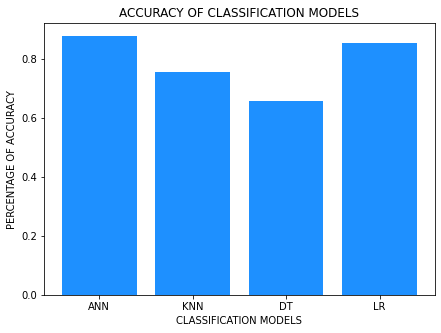

In [ ]:
# BAR PLOT FOR ACCURACY
import matplotlib.pyplot as plt

acc = []
ANN = classifier.evaluate(X_test, y_test,batch_size=25)
KNN = metrics.accuracy_score(y_test,knn_pred)
DT = metrics.accuracy_score(y_test,dec_pred)
LR = metrics.accuracy_score(y_test,pred_logit)

acc.append(ANN[1])
acc.append(KNN)
acc.append(DT)
acc.append(LR)

models = ['ANN', 'KNN' ,'DT', 'LR']

# creating the bar plot
fig, axes = plt.subplots(figsize=(7,5))
plt.bar(models,acc,color="dodgerblue")
plt.xlabel("CLASSIFICATION MODELS")
plt.ylabel("PERCENTAGE OF ACCURACY")
plt.title("ACCURACY OF CLASSIFICATION MODELS")
plt.show()


In [ ]:
# K-FOLD CROSS VALIDATION
def kfold_cross_validation(num,model):
 kfold = KFold(n_splits=num)
 results = cross_val_score(model, X, y,cv=kfold)
 r = results.mean()
 return r

print("KFOLD CROSS VALIDATION SCORE\n")

print("\nLOGISTIC REGRESSION :",kfold_cross_validation(30,logreg))
print("\nDECISION TREE  :",kfold_cross_validation(30,dectree))
print("\nKNN CLASSIFIER :",kfold_cross_validation(30,knn))

print("\n\n\n\n")

KFOLD CROSS VALIDATION SCORE


LOGISTIC REGRESSION : 0.7650793650793649

DECISION TREE  : 0.6420634920634922

KNN CLASSIFIER : 0.6904761904761905







In [ ]:
# K-FOLD CROSS VALIDATION FOR ANN

import warnings
warnings.filterwarnings('ignore')

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def build_classifier():
  model = Sequential()
  model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='softmax'))
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model 

kfold = KFold(n_splits=30)

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 25, epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = kfold)
mean = accuracies.mean()
print('mean : ' ,mean)

Streaming output truncated to the last 5000 lines.
Epoch 14/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.9745
Epoch 15/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1455 - accuracy: 0.9745
Epoch 16/100
7/7 [==============================] - 0s 4ms/step - loss: 0.1247 - accuracy: 0.9809
Epoch 17/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1091 - accuracy: 0.9745
Epoch 18/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0928 - accuracy: 0.9873
Epoch 19/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0778 - accuracy: 0.9873
Epoch 20/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.9936
Epoch 21/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0545 - accuracy: 1.0000
Epoch 22/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0483 - accuracy: 1.0000
Epoch 23/100
7/7 [==============================] - 0s 3ms/step - l

In [ ]:
# CROSS VALIDATION
def cross_validation(model):
 score = cross_val_score(model ,X,y,cv=30)
 avg_score = np.average(score)
 return avg_score

print("CROSS VALIDATION SCORE\n")
print("\nLOGISTIC REGRESSION :",cross_validation(logreg))
print("\nDECISION TREE  :",cross_validation(dectree))
print("\nKNN CLASSIFIER :",cross_validation(knn))


CROSS VALIDATION SCORE


LOGISTIC REGRESSION : 0.8253968253968255

DECISION TREE  : 0.6507936507936508

KNN CLASSIFIER : 0.7206349206349204


In [ ]:
# CROSS VALIDATION FOR ANN

import warnings
warnings.filterwarnings('ignore')

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def build_classifier():
  model = Sequential()
  model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='softmax'))
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model 

cclassifier = KerasClassifier(build_fn = build_classifier, batch_size = 25, epochs = 100)
accuracies = cross_val_score(estimator = cclassifier, X = X_train, y = y_train, cv = 30)
mean = accuracies.mean()
print('mean : ' ,mean)

Streaming output truncated to the last 5000 lines.
Epoch 14/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2074 - accuracy: 0.9554
Epoch 15/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.9618
Epoch 16/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.9618
Epoch 17/100
7/7 [==============================] - 0s 4ms/step - loss: 0.1349 - accuracy: 0.9809
Epoch 18/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1160 - accuracy: 0.9936
Epoch 19/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1004 - accuracy: 0.9936
Epoch 20/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0830 - accuracy: 1.0000
Epoch 21/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0725 - accuracy: 1.0000
Epoch 22/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0623 - accuracy: 1.0000
Epoch 23/100
7/7 [==============================] - 0s 4ms/step - l

In [ ]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report

class_rep_tree = classification_report(y_test, dec_pred)
class_rep_log = classification_report(y_test, pred_logit)
class_rep_knn = classification_report(y_test,knn_pred)


print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("KNN: \n", class_rep_knn)


Decision Tree: 
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.78      1.00      0.88         7
           2       0.56      0.50      0.53        10
           3       0.65      0.65      0.65        17

    accuracy                           0.66        41
   macro avg       0.66      0.68      0.67        41
weighted avg       0.65      0.66      0.65        41

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      1.00      1.00         7
           2       0.89      0.80      0.84        10
           3       0.87      0.76      0.81        17

    accuracy                           0.85        41
   macro avg       0.86      0.89      0.87        41
weighted avg       0.87      0.85      0.85        41

KNN: 
               precision    recall  f1-score   support

           0       0.62     

In [ ]:
from sklearn.metrics import f1_score,recall_score,precision_score
#PREDICTION WITH CLASSIFIER 

print('Recall: %.3f' % recall_score(y_test, predict, average='macro'))
print('F1 Score: %.3f' % f1_score(y_test, predict, average='macro'))
print('Precision: %.3f' % precision_score(y_test, predict, average='macro'))


Recall: 0.885
F1 Score: 0.879
Precision: 0.896


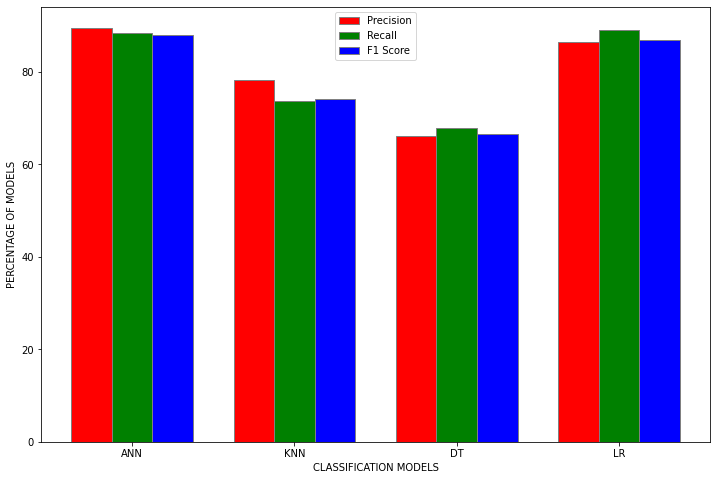

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

precision = []
pANN = precision_score(y_test, predict, average='macro')*100
pKNN = precision_score(y_test, knn_pred, average='macro')*100
pDT = precision_score(y_test, dec_pred, average='macro')*100
pLR = precision_score(y_test, pred_logit, average='macro')*100
precision.append(pANN)
precision.append(pKNN)
precision.append(pDT)
precision.append(pLR)

recall = []
rANN = recall_score(y_test, predict, average='macro')*100
rKNN = recall_score(y_test, knn_pred, average='macro')*100
rDT = recall_score(y_test, dec_pred, average='macro')*100
rLR = recall_score(y_test, pred_logit, average='macro')*100
recall.append(rANN)
recall.append(rKNN)
recall.append(rDT)
recall.append(rLR)


f1 = []
fANN = f1_score(y_test, predict, average='macro')*100
fKNN = f1_score(y_test, knn_pred, average='macro')*100
fDT = f1_score(y_test, dec_pred, average='macro')*100
fLR = f1_score(y_test, pred_logit, average='macro')*100
f1.append(fANN)
f1.append(fKNN)
f1.append(fDT)
f1.append(fLR)


# Set position of bar on X axis
br1 = np.arange(len(precision))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, precision, color ='r', width = barWidth,
		edgecolor ='grey', label ='Precision')
plt.bar(br2, recall, color ='g', width = barWidth,
		edgecolor ='grey', label ='Recall')
plt.bar(br3, f1, color ='b', width = barWidth,
		edgecolor ='grey', label ='F1 Score')

# Adding Xticks
plt.xlabel('CLASSIFICATION MODELS')
plt.ylabel('PERCENTAGE OF MODELS')
plt.xticks([r + barWidth for r in range(len(precision))],
		['ANN','KNN', 'DT', 'LR'])

plt.legend()
plt.show()


Streaming output truncated to the last 5000 lines.
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4154 - accuracy: 0.8923
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3398 - accuracy: 0.9179
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.9333
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2291 - accuracy: 0.9538
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.9590
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1623 - accuracy: 0.9641
Epoch 13/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1384 - accuracy: 0.9692
Epoch 14/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1162 - accuracy: 0.9641
Epoch 15/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0964 - accuracy: 0.9795
Epoch 16/100
8/8 [==============================] - 0s 3ms/step - loss

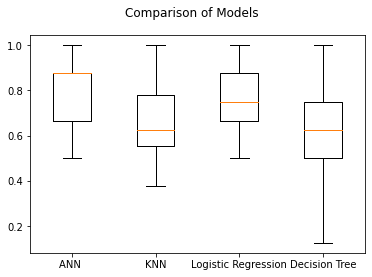

In [ ]:
models = []
models.append(('ANN ',classifier))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Logistic Regression', LogisticRegression(random_state=24)))
models.append(('Decision Tree',DecisionTreeClassifier(random_state=24)))


#Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=25)
  cv_results = cross_val_score(model, X,y, cv=kfold, scoring=scoring)
  results.append (cv_results)
  names.append(name)
  print("\n")
  msg = "%s : %f " % (name, cv_results.mean( ))
  print(msg)

#boxplot algorithm comparison
fig=plt.figure()
fig.suptitle( 'Comparison of Models')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
